# Fit emission lines in Sitelle data <a class="tocSkip">

This notebook is used to run the ORBS pipeline to create [OII] linemaps from the raw hdf5 cubes. Any further analysis should go in the dedicated notebooks.
    
* [ORB](https://orb.readthedocs.io) documentation
* [ORCS](https://orcs.readthedocs.io/en/latest/index.html) documentation
* [ORBS](https://github.com/thomasorb/orbs) github

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

import sys
import logging
from pathlib import Path
import warnings
import yaml

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits,ascii
from astropy.table import Table, vstack, join

from astropy.wcs import WCS
from astropy.coordinates import Distance,SkyCoord

from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData, Cutout2D

import astropy.constants as c
import astropy.units as u

from reproject import reproject_interp
%config InlineBackend.figure_format='retina'

In [4]:
plt.style.use('Tex.mplstyle')

logging.basicConfig(stream=sys.stdout,format='%(levelname)s: %(message)s',level=logging.INFO)
logger = logging.getLogger(__name__)

single_column = 3.321 # in inch
two_column    = 6.974 # in inch

basedir  = Path('.')
data_raw = Path('/mnt/g/') 

output_folder = 'data_v2p1'

## Read in data

the complete data set is only needed to extract the spectra or make a line map

it might be necassary to mount the external drive first
`sudo mount -t drvfs a: /mnt/a`


In [5]:
from orcs.process import SpectralCube
import yaml

name = 'NGC0628'

filename = data_raw / 'SITELLE' /f'{name}_cube.hdf5'
cube = SpectralCube(filename)
print(cube.params['object_name'])

# the WCS information in the fits cubes is correct
filename = data_raw/'SITELLE'/f'{name}_cube.fits'
with fits.open(filename) as hdul:
    header = hdul[0].header
wcs = WCS(header,naxis=2)
#cube.set_wcs(wcs)

# read in the deepframe file to get the correct 2d header
filename = data_raw/'SITELLE'/f'{name}_deepframe.fits'
with fits.open(filename) as hdul:
    deepframe = NDData(data=hdul[0].data,
                    meta=hdul[0].header,
                    # for some reason the deepframe does not contain a valid WCS information
                    wcs=wcs)    
    
params = cube.params
parameter_file = basedir/output_folder/'params'/f'{name}_params.yaml'
if not parameter_file.is_file() or True:
    print('saving cube parameters to file')
    keys = ['object_name','date','dimx','dimy','dimz','step','order','nm_laser','axis_corr','zpd_index']
    dic = {key:params.get(key) for key in keys}
    dic['channel_width'] = float(params.base_axis[1] - params.base_axis[0])
    for k,v in dic.items():
        if isinstance(v,np.int64):
            dic[k] = int(v)
    with open(parameter_file,'w+') as f:
        yaml.dump(dic,f)
else:  
    with open(parameter_file) as f:
        params = yaml.load(f,Loader=yaml.SafeLoader)
    
# save deepframe with correct wcs
#primary_hdu = fits.PrimaryHDU(data=deepframe.data,header=deepframe.meta)
#primary_hdu.writeto(basedir/'data'/f'{name}_deepframe.fits',overwrite=True)

INFO: Cube is level 1
INFO: shape: (2048, 2064, 105)
INFO: wavenumber calibration: True
INFO: flux calibration: True
INFO: wcs calibration: True
NGC628
saving cube parameters to file


In [6]:
DR = 'DR2.1'

if DR=='DR1':
    catalogue_file = data_raw/'MUSE_DR1'/'Nebulae catalogue'/'Nebulae_Catalogue.fits' 
    filter_file = data_raw/'MUSE_DR1'/'filterImages'/f'{name}_IMAGE_FOV_Johnson_B.fits'
    mask_file = data_raw/'MUSE_DR1'/'Nebulae catalogue'/'spatial_masks'/f'{name}_HIIreg_mask.fits'.format(name) 
elif DR=='DR2.0':
    catalogue_file = data_raw/'MUSE_DR2.0'/'Nebulae catalogue'/'Nebulae_Catalogue_DR2_native.fits' 
    filter_file = data_raw/'MUSE_DR2.0'/'filterImages'/f'{name}_IMAGE_FOV_Johnson_B_WCS_Pall_mad.fits'
    halpha_file = data_raw/'MUSE_DR2.0'/'MUSEDAP'/f'{name}_MAPS.fits'
    mask_file = data_raw/'MUSE_DR2.0'/'Nebulae catalogue'/'spatial_masks'/f'{name}_HIIreg_mask.fits'.format(name) 
else:
    catalogue_file = data_raw/'MUSE_DR2.1'/'Nebulae catalogue'/'Nebulae_catalogue_v2.fits' 
    filter_file = data_raw/'MUSE_DR2.1'/'filterImages'/f'{name}_IMAGE_FOV_Johnson_B_WCS_Pall_mad.fits'
    halpha_file = data_raw/'MUSE_DR2.1'/'MUSEDAP'/f'{name}_MAPS.fits'
    mask_file = data_raw/'MUSE_DR2.1'/'Nebulae catalogue'/'spatial_masks'/f'{name}_nebulae_mask.fits'.format(name) 
print(f'using {DR}')
    
with fits.open(catalogue_file) as hdul:
    nebulae_catalogue = Table(hdul[1].data)

# muse image for reprojection
with fits.open(filter_file) as hdul:    
    muse_data = NDData(data=hdul['DATA'].data,
                    mask=np.isnan(hdul['DATA'].data),
                    meta=hdul['DATA'].header,
                    wcs=WCS(hdul['DATA'].header))    
    muse_data.data[muse_data.data==0] = np.nan

with fits.open(halpha_file) as hdul:    
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))    
    Halpha.data[muse_data.data==0] = np.nan
    
with fits.open(mask_file) as hdul:
    nebulae_mask = NDData(hdul[0].data.astype(float),mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan

nebulae_catalogue = nebulae_catalogue[nebulae_catalogue['gal_name']==name]
nebulae_catalogue.add_index('region_ID')
nebulae_catalogue['SkyCoord'] = SkyCoord(nebulae_catalogue['cen_ra']*u.degree,nebulae_catalogue['cen_dec']*u.degree)
print('{} nebulae in {}'.format(len(nebulae_catalogue),name))
print('{} regions in masks'.format(len(np.unique(nebulae_mask.data[~np.isnan(nebulae_mask.data)]))))

from region import Regions
        
muse_regions = Regions(mask=nebulae_mask.data,projection=nebulae_mask.meta,bkg=-1)

using DR2.1
2869 nebulae in NGC0628
2869 regions in masks
INFO: initialized with 2869 regions


## Extract spectra from regions

In [69]:
# determine the limits of the muse data in the sitelle image
a, footprint = reproject_interp(muse_data,output_projection=wcs,shape_out=deepframe.data.shape)

xvalues = np.where(np.any(footprint,axis=0))
xmin,xmax = np.min(xvalues),np.max(xvalues)
yvalues = np.where(np.any(footprint,axis=1))
ymin,ymax = np.min(yvalues),np.max(yvalues)

INFO: initialized with 1938 regions


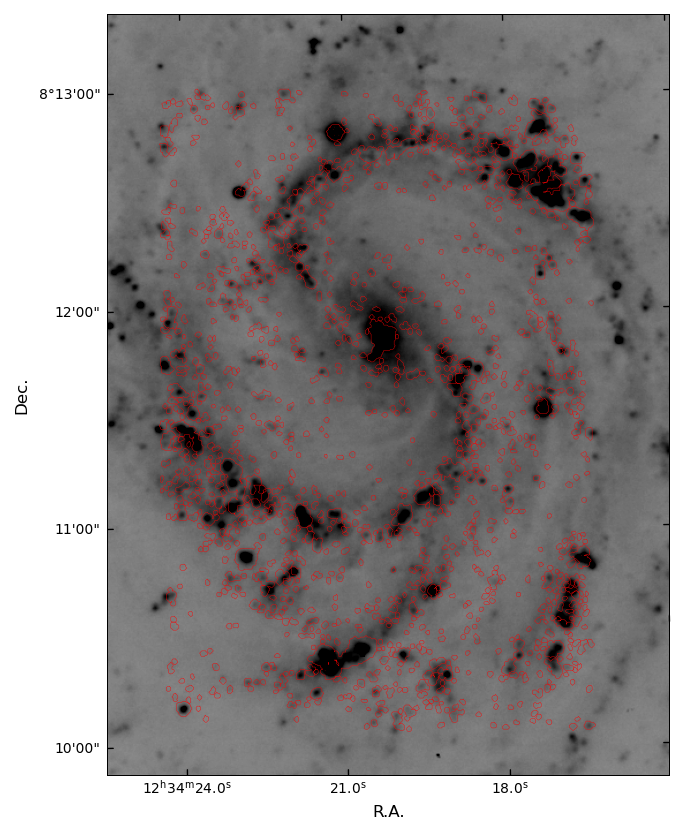

In [70]:
sitelle_regions = muse_regions.reproject(wcs,shape=deepframe.data.shape)
sitelle_regions.plot(image=deepframe.data,regions=False,
                     filename=basedir/'reports'/name/f'{name}_sitelle_regions.png',
                     xlim=[0.95*xmin,1.05*xmax],ylim=[0.95*ymin,1.05*ymax],xlabel='R.A.',ylabel='Dec.', 
                     percent=99.6)

In [71]:
region_id = []
axis      = []
spectrum  = []

for reg,label in zip(sitelle_regions.coords,sitelle_regions.labels):

    # ORCS expects y,x coordinates
    a,s = cube.extract_integrated_spectrum(reg[::-1])

    region_id.append(label)
    axis.append(np.float64(a))
    spectrum.append(np.real(s))
        

spectra = Table(data=[region_id,axis,spectrum],
                names=['region_ID','axis','spectrum'])

spectra['axis'] /= u.cm
spectra['spectrum'] *= u.erg/u.cm**2/u.s/u.AA

hdu = fits.BinTableHDU(spectra,name='spectra')
hdu.writeto(basedir/output_folder/'spectra'/f'{name}_spectra_SN1.fits',overwrite=True)
    

 [==========] [100%] [completed in 0.126 s]                                   
 [==========] [100%] [completed in 0.047 s]                                   
 [==========] [100%] [completed in 0.078 s]                                   
 [==========] [100%] [completed in 0.296 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.060 s]                                   
 [==========] [100%] [completed in 0.342 s]                                   
 [==========] [100%] [completed in 0.136 s]                                   
 [==========] [100%] [completed in 0.048 s]                                   
 [==========] [100%] [completed in 0.053 s]                                   
 [==========] [100%] [completed in 0.067 s]                                   
 [==========] [100%] [completed in 0.052 s]                                   
 [==========] [100%] [completed in 0.106 s]         

 [==========] [100%] [completed in 0.043 s]                                   
 [==========] [100%] [completed in 0.041 s]                                   
 [==========] [100%] [completed in 0.044 s]                                   
 [==========] [100%] [completed in 0.037 s]                                   
 [==========] [100%] [completed in 0.040 s]                                   
 [==========] [100%] [completed in 0.034 s]                                   
 [==========] [100%] [completed in 0.031 s]                                   
 [==========] [100%] [completed in 0.035 s]                                   
 [==========] [100%] [completed in 0.055 s]                                   
 [==========] [100%] [completed in 0.035 s]                                   
 [==========] [100%] [completed in 0.037 s]                                   
 [==========] [100%] [completed in 0.041 s]                                   
 [==========] [100%] [completed in 0.035 s]         

 [==========] [100%] [completed in 0.041 s]                                   
 [==========] [100%] [completed in 0.068 s]                                   
 [==========] [100%] [completed in 0.057 s]                                   
 [==========] [100%] [completed in 0.044 s]                                   
 [==========] [100%] [completed in 0.042 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.046 s]                                   
 [==========] [100%] [completed in 0.047 s]                                   
 [==========] [100%] [completed in 0.032 s]                                   
 [==========] [100%] [completed in 0.046 s]                                   
 [==========] [100%] [completed in 0.054 s]                                   
 [==========] [100%] [completed in 0.064 s]                                   
 [==========] [100%] [completed in 0.036 s]         

 [==========] [100%] [completed in 0.033 s]                                   
 [==========] [100%] [completed in 0.033 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.034 s]                                   
 [==========] [100%] [completed in 0.038 s]                                   
 [==========] [100%] [completed in 0.032 s]                                   
 [==========] [100%] [completed in 0.034 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.045 s]                                   
 [==========] [100%] [completed in 0.033 s]                                   
 [==========] [100%] [completed in 0.035 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.031 s]         

 [==========] [100%] [completed in 0.074 s]                                   
 [==========] [100%] [completed in 0.054 s]                                   
 [==========] [100%] [completed in 0.052 s]                                   
 [==========] [100%] [completed in 0.052 s]                                   
 [==========] [100%] [completed in 0.071 s]                                   
 [==========] [100%] [completed in 0.045 s]                                   
 [==========] [100%] [completed in 0.143 s]                                   
 [==========] [100%] [completed in 0.075 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.034 s]                                   
 [==========] [100%] [completed in 0.035 s]                                   
 [==========] [100%] [completed in 0.040 s]         

 [==========] [100%] [completed in 0.056 s]                                   
 [==========] [100%] [completed in 0.053 s]                                   
 [==========] [100%] [completed in 0.055 s]                                   
 [==========] [100%] [completed in 0.042 s]                                   
 [==========] [100%] [completed in 0.053 s]                                   
 [==========] [100%] [completed in 0.033 s]                                   
 [==========] [100%] [completed in 0.053 s]                                   
 [==========] [100%] [completed in 0.117 s]                                   
 [==========] [100%] [completed in 0.052 s]                                   
 [==========] [100%] [completed in 0.114 s]                                   
 [==========] [100%] [completed in 0.041 s]                                   
 [==========] [100%] [completed in 0.040 s]                                   
 [==========] [100%] [completed in 0.038 s]         

 [==========] [100%] [completed in 0.035 s]                                   
 [==========] [100%] [completed in 0.060 s]                                   
 [==========] [100%] [completed in 0.045 s]                                   
 [==========] [100%] [completed in 0.068 s]                                   
 [==========] [100%] [completed in 0.042 s]                                   
 [==========] [100%] [completed in 0.062 s]                                   
 [==========] [100%] [completed in 0.037 s]                                   
 [==========] [100%] [completed in 0.053 s]                                   
 [==========] [100%] [completed in 0.046 s]                                   
 [==========] [100%] [completed in 0.040 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.056 s]                                   
 [==========] [100%] [completed in 0.034 s]         

 [==========] [100%] [completed in 0.041 s]                                   
 [==========] [100%] [completed in 0.038 s]                                   
 [==========] [100%] [completed in 0.046 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.044 s]                                   
 [==========] [100%] [completed in 0.032 s]                                   
 [==========] [100%] [completed in 0.036 s]                                   
 [==========] [100%] [completed in 0.045 s]                                   
 [==========] [100%] [completed in 0.048 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.037 s]                                   
 [==========] [100%] [completed in 0.044 s]         

 [==========] [100%] [completed in 0.109 s]                                   
 [==========] [100%] [completed in 0.099 s]                                   
 [==========] [100%] [completed in 0.074 s]                                   
 [==========] [100%] [completed in 0.061 s]                                   
 [==========] [100%] [completed in 0.048 s]                                   
 [==========] [100%] [completed in 0.045 s]                                   
 [==========] [100%] [completed in 0.038 s]                                   
 [==========] [100%] [completed in 0.051 s]                                   
 [==========] [100%] [completed in 0.103 s]                                   
 [==========] [100%] [completed in 0.051 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.066 s]                                   
 [==========] [100%] [completed in 0.041 s]         

 [==========] [100%] [completed in 0.043 s]                                   
 [==========] [100%] [completed in 0.046 s]                                   
 [==========] [100%] [completed in 0.043 s]                                   
 [==========] [100%] [completed in 0.042 s]                                   
 [==========] [100%] [completed in 0.057 s]                                   
 [==========] [100%] [completed in 0.049 s]                                   
 [==========] [100%] [completed in 0.049 s]                                   
 [==========] [100%] [completed in 0.039 s]                                   
 [==========] [100%] [completed in 0.055 s]                                   
 [==========] [100%] [completed in 0.044 s]                                   
 [==========] [100%] [completed in 0.069 s]                                   
 [==========] [100%] [completed in 0.066 s]                                   
 [==========] [100%] [completed in 0.062 s]         

## Fit emission line in spectra

we already extracted all spectra and saved them in a file. Here we load this file and fit the [OII] doublet to the spectra

### Define parameters and functions

In [72]:
from dust_extinction.parameter_averages import O94, CCM89

extinction_model = CCM89(Rv=3.1)

def extinction(EBV,EBV_err,wavelength,plot=False):
    '''Calculate the extinction for a given EBV and wavelength with errors
    
    flux_corr = flux / ext
    '''
    
    EBV = np.atleast_1d(EBV)
    sample_size = 100000

    ext = extinction_model.extinguish(wavelength,Ebv=EBV)
    
    EBV_rand = np.random.normal(loc=EBV,scale=EBV_err,size=(sample_size,len(EBV)))
    ext_arr  = extinction_model.extinguish(wavelength,Ebv=EBV_rand)
        
    ext_err  = np.std(ext_arr,axis=0)
    ext_mean = np.mean(ext_arr,axis=0)
    
    if plot:
        fig,(ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(two_column,two_column/2))
        ax1.hist(EBV_rand[:,0],bins=100)
        ax1.axvline(EBV[0],color='black')
        ax1.set(xlabel='E(B-V)')
        ax2.hist(ext_arr[:,0],bins=100)
        ax2.axvline(ext[0],color='black')
        ax2.set(xlabel='extinction')
        plt.show()
 
    return ext,ext_err

all the data necessary to make a fit is located in the sitelle folder and read in here.

In [73]:
from orb.fit import fit_lines_in_spectrum
from orb.core import Lines
from orb.utils.spectrum import corr2theta, amp_ratio_from_flux_ratio
import gvar

print(name)
# table with the extracted spectra
with fits.open(basedir/output_folder/'spectra'/f'{name}_spectra_SN1.fits') as hdul:
    spectra = Table(hdul[1].data)
spectra.add_index('region_ID')

# parameters from the cube, needed for the fit
parameter_file = basedir/output_folder/'params'/f'{name}_params.yaml'
with open(parameter_file) as f:
    params = yaml.load(f,Loader=yaml.SafeLoader)
    
# the nebulae catalogue (needed for EBV of individual regions)
with fits.open(basedir/output_folder/'Nebulae_catalogue_v2.fits') as hdul:
    nebulae_catalogue = Table(hdul[1].data)
nebulae_catalogue = nebulae_catalogue[nebulae_catalogue['gal_name']==name]
nebulae_catalogue.add_index('region_ID')
nebulae_catalogue['SkyCoord'] = SkyCoord(nebulae_catalogue['cen_ra']*u.degree,nebulae_catalogue['cen_dec']*u.degree)


distances = {
             'IC5332':29.736,'NGC0628':29.9,'NGC1087':30.352,'NGC1300':32.065,'NGC1365':31.242,
             'NGC1385':29.659,'NGC1433':31.369,'NGC1512':31.506,'NGC1566':30.884,'NGC1672':30.788,
             'NGC2835':30.563,'NGC3351':30.338,'NGC3627':30.133,'NGC4254':30.102,'NGC4303':30.688,
             'NGC4321':31.121,'NGC4535':30.99,'NGC5068':28.475,'NGC7496':31.347,
            }

# EBV of the galaxies
EBV = {'IC5332': 0.015,'NGC0628': 0.062,'NGC1087': 0.03,'NGC1300': 0.026,'NGC1365': 0.018,
       'NGC1385': 0.018,'NGC1433': 0.008,'NGC1512': 0.009,'NGC1566': 0.008,'NGC1672': 0.021,
       'NGC2835': 0.089,'NGC3351': 0.024,'NGC3627': 0.037,'NGC4254': 0.035,'NGC4303': 0.02,
       'NGC4321': 0.023,'NGC4535': 0.017,'NGC5068': 0.091,'NGC7496': 0.008}

H0 = 70 * u.km / u.s / u.Mpc
velocity = H0*Distance(distmod=distances[name])
z = (velocity / c.c).decompose().value

print(f'velocity={velocity:.1f},z={z:.3f}')

OII3726 = Lines().get_line_cm1('[OII]3726')
OII3729 = Lines().get_line_cm1('[OII]3729')

# channel_width in km/s (velocity must be more precise than this)
#channel_width = cube.params.base_axis[1] - cube.params.base_axis[0]
#print(f'channel width: {(c.c * channel_width / OII3726).to(u.km/u.s):.2f}')

NGC4535
velocity=1104.3 km / s,z=0.004


In [95]:
def fit_spectrum(spectrum,params,velocity_guess,SNR_guess,mode='bayes'):
    '''fit the OII doublet in a SITELLE data cube
    
    https://orcs.readthedocs.io/en/latest/script_example_model%2Bfit_2_lines_bayes.html
    '''

    # the two lines 
    OII3726 = Lines().get_line_cm1('[OII]3726')
    OII3729 = Lines().get_line_cm1('[OII]3729')
    
    # get parameters from the cube/header
    step       = params.get("step")
    order      = params.get("order")
    nm_laser   = params.get("nm_laser")
    theta      = corr2theta(params.get("axis_corr"))
    zpd_index  = params.get("zpd_index")
    
    amp_ratio = amp_ratio_from_flux_ratio(OII3726,OII3729,1.4)
    
    # constrain the velocity based on the distance/redshift
    velocity_gvar = gvar.gvar(velocity_guess,150)
    broadening_gvar = gvar.gvar(1, 150)
    
    if mode=='classic':
        fit = fit_lines_in_spectrum(spectrum, ['[OII]3726', '[OII]3729'], 
                                    step,order,nm_laser,theta,zpd_index,
                                    wavenumber=True, apodization=1, fmodel='sincgauss',
                                    pos_def=['1', '1'],
                                    pos_cov=[velocity_guess],
                                    amp_def=['1','1'],
                                    amp_guess=[1, amp_ratio],
                                    sigma_guess=[10,10]
                                    )
    if mode=='bayes':
        fit = fit_lines_in_spectrum(spectrum, [OII3726, OII3729], 
                                    step,order,nm_laser,theta,zpd_index,
                                    wavenumber=True, apodization=1, fmodel='sincgauss',
                                    pos_def=['1', '1'],
                                    pos_cov=[velocity_gvar],
                                    amp_def=['1','1'],
                                    amp_guess=[1, amp_ratio],
                                    sigma_def='free',
                                    sigma_guess=[broadening_gvar,broadening_gvar],
                                    snr_guess=SNR_guess
                                    )
    
    return fit

# 303, 53,637,525
region_ID = 13 #result[np.argmax(result['OII3727_FLUX'])]['region_ID']
axis,spectrum = spectra.loc[region_ID][['axis','spectrum']]
SNR_old = 3 #result.loc[region_ID]['OII3727_FLUX']/result.loc[region_ID]['OII3727_FLUX_ERR']

fit = fit_spectrum(spectrum,params,velocity.value,SNR_guess=SNR_old,mode='bayes')

print(f"SNR old: {SNR_old:.3f}")
print(f"SNR new: {fit['flux'][0]/fit['flux_err'][0]:.3f}")
print(f"[OII]I3729/[OII]3726: {fit['flux'][1]/fit['flux'][0]:.3f}")

SNR old: 3.000
SNR new: 1.747
[OII]I3729/[OII]3726: 1.404


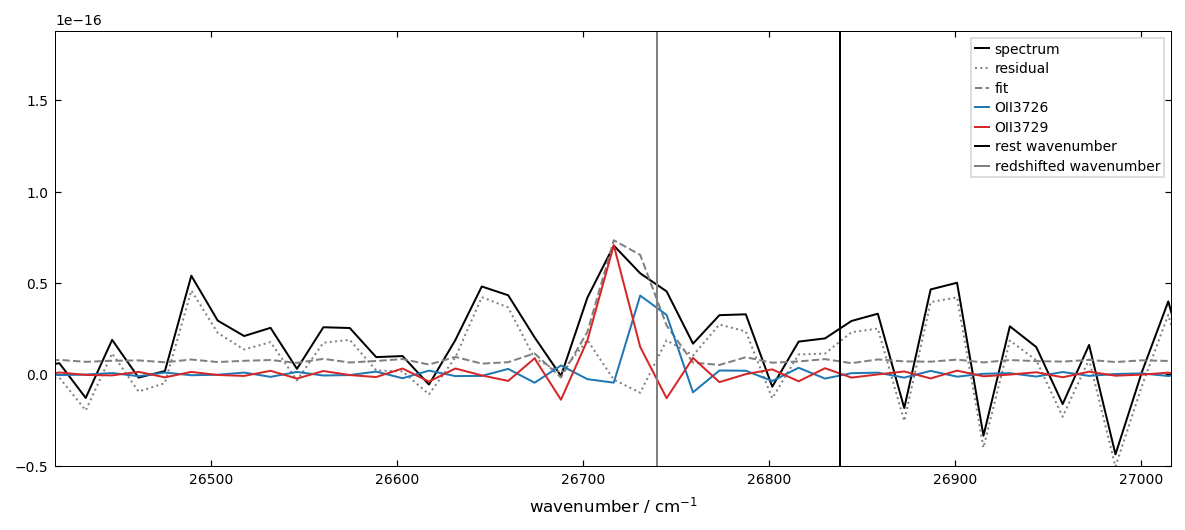

In [96]:
fig,ax = plt.subplots(figsize=(10,4))
residual = fit.get_residual().data
position = fit['lines_params'][1][2]

ax.plot(axis, spectrum, label='spectrum',color='black')
ax.plot(axis, residual, label='residual',ls=':',color='grey')

OII3726_fit, OII3729_fit = fit['fitted_models']['Cm1LinesModel']

ax.plot(axis, fit['fitted_vector'], label='fit', ls='--', c='grey')
ax.plot(axis,OII3726_fit,label='OII3726',color='tab:blue')
ax.plot(axis,OII3729_fit,label='OII3729',color='tab:red')

ax.axvline(OII3726,color='black',label='rest wavenumber')
ax.axvline(OII3726/(1+z),color='gray',label='redshifted wavenumber')

ax.set(xlim=[position-300,position+300],ylim=[-0.5e-16,None],xlabel=r'wavenumber / cm$^{-1}$',)
ax.legend()

### The main loop

In [97]:
from tqdm import tqdm

extinction_model = CCM89(Rv=3.1)
extinction_mw26  = extinction_model.extinguish(3626*u.angstrom,Ebv=0.5*EBV[name])
extinction_mw29  = extinction_model.extinguish(3629*u.angstrom,Ebv=0.5*EBV[name])

# table to save the fluxes
fluxes = Table(data=np.full((len(spectra),13),fill_value=np.nan),
               names=['region_ID','OII3726_FLUX','OII3729_FLUX','OII3726_FLUX_ERR','OII3729_FLUX_ERR',
                      'OII3726_FLUX_CORR','OII3729_FLUX_CORR','OII3726_FLUX_CORR_ERR','OII3729_FLUX_CORR_ERR',
                      'OII3726_velocity','OII3729_velocity','OII3726_broadening','OII3729_broadening'])
fluxes.add_column(name,index=0,name='gal_name')
fluxes['region_ID'] = list(spectra['region_ID'])
fluxes.add_index('region_ID')

# table to save the line parameters
lines_params = Table(data=np.full((len(spectra),11),fill_value=np.nan),
               names=['region_ID','height_OII3726','amp_OII3726','pos_OII3726','fwhm_OII3726','sigma_OII3726',
                      'height_OII3729','amp_OII3729','pos_OII3729','fwhm_OII3729','sigma_OII3729'])
lines_params['region_ID'] = list(spectra['region_ID'])
lines_params.add_index('region_ID')

# table to save the fitted vector
fit_table = spectra.copy()
fit_table['OII3726'] = 0*spectra['spectrum']
fit_table['OII3729'] = 0*spectra['spectrum']
fit_table['fit'] = 0*spectra['spectrum']


for region_ID in tqdm(fluxes['region_ID']):
    
    axis,spectrum = spectra.loc[region_ID][['axis','spectrum']]

    # we run each fit twice. First with the SNR guess from the classic fit
    try:
        SNR = 3 #result.loc[region_ID]['OII3727_FLUX'] / result.loc[region_ID]['OII3727_FLUX_ERR']    
        fit = fit_spectrum(spectrum,params,velocity,SNR)
        #SNR = fit['snr'][0] #fit['flux'][0]/fit['flux_err'][0]
        position = fit['lines_params'][1][2]
        residual = fit.get_residual().data
        amp = fit['lines_params'][1][1]
        std = np.std(residual[(axis>position-100)&(axis<position+100)])
        SNR = amp/std
        fit = fit_spectrum(spectrum,params,velocity,SNR)
        
        # save the line parameters
        lines_params.loc[region_ID][list(lines_params.columns[1:])] = fit['lines_params'].flatten()
        
        # save the fit result
        OII3726_fit, OII3729_fit = fit['fitted_models']['Cm1LinesModel']        
        fit_table.loc[region_ID]['OII3726'] = OII3726_fit
        fit_table.loc[region_ID]['OII3729'] = OII3729_fit
        fit_table.loc[region_ID]['fit']     = fit['fitted_vector']

        # the main table
        fluxes.loc[region_ID]['OII3726_FLUX','OII3729_FLUX']             = 1e20*fit['flux']
        fluxes.loc[region_ID]['OII3726_FLUX_ERR','OII3729_FLUX_ERR']     = 1e20*fit['flux_err']
        fluxes.loc[region_ID]['OII3726_velocity','OII3729_velocity']     = fit['velocity']
        fluxes.loc[region_ID]['OII3726_broadening','OII3729_broadening'] = fit['broadening']
        
        # correct for extinction
        fluxes.loc[region_ID]['OII3726_FLUX'] /= extinction_mw26
        fluxes.loc[region_ID]['OII3729_FLUX'] /= extinction_mw29

        ebv,ebv_err = nebulae_catalogue.loc[region_ID][['EBV','EBV_ERR']]
    
        ext_int,ext_int_err = extinction(ebv,ebv_err,wavelength=3627*u.angstrom)
        fluxes.loc[region_ID]['OII3726_FLUX_CORR'] = fluxes.loc[region_ID]['OII3726_FLUX'] / ext_int
        fluxes.loc[region_ID]['OII3726_FLUX_CORR_ERR'] = fluxes.loc[region_ID]['OII3726_FLUX_CORR']*np.sqrt((fluxes.loc[region_ID]['OII3726_FLUX_ERR']/fluxes.loc[region_ID]['OII3726_FLUX'])**2 + (ext_int_err/ext_int)**2)  

        ext_int,ext_int_err = extinction(ebv,ebv_err,wavelength=3629*u.angstrom)
        fluxes.loc[region_ID]['OII3729_FLUX_CORR'] = fluxes.loc[region_ID]['OII3729_FLUX'] / ext_int
        fluxes.loc[region_ID]['OII3729_FLUX_CORR_ERR'] = fluxes.loc[region_ID]['OII3729_FLUX_CORR']*np.sqrt((fluxes.loc[region_ID]['OII3729_FLUX_ERR']/fluxes.loc[region_ID]['OII3729_FLUX'])**2 + (ext_int_err/ext_int)**2)  

    except:
        print(f'error for {region_ID}')

# save the table with the fluxes
hdu = fits.BinTableHDU(fluxes,name='fluxes')
hdu.writeto(basedir/output_folder/'fluxes'/f'{name}_OII_fluxes.fits',overwrite=True)

# save the table with the fitted vector
fit_table['OII3726'] *= u.erg/u.cm**2/u.s/u.AA
fit_table['OII3729'] *= u.erg/u.cm**2/u.s/u.AA
fit_table['fit'] *= u.erg/u.cm**2/u.s/u.AA
hdu = fits.BinTableHDU(fit_table,name='fit')
hdu.writeto(basedir/output_folder/'fit'/f'{name}_fit_SN1.fits',overwrite=True)

# save the table with the line parameters
hdu = fits.BinTableHDU(lines_params,name='line_params')
hdu.writeto(basedir/output_folder/'line_params'/f'{name}_line_params.fits',overwrite=True)


100%|██████████| 1938/1938 [34:51<00:00,  1.08s/it] 


### Combine all galaxies into one single file

In [98]:
with fits.open(basedir/'data_v2p1'/'Nebulae_catalogue_v2.fits') as hdul:
    nebulae = Table(hdul[1].data)
    
tables = []
for file in [x for x in (basedir/'data_v2p1'/'fluxes').iterdir() if x.stem.endswith('OII_fluxes')]:  
    with fits.open(file) as hdul:
        OII_fluxes = Table(hdul[1].data)    
    tables.append(OII_fluxes)
OII_fluxes = vstack(tables)

for col in list(OII_fluxes.columns):
    if col.endswith('broadening'):
        del OII_fluxes[col]
catalogue = join(nebulae[['gal_name','region_ID']],OII_fluxes,keys=['gal_name','region_ID'],join_type='outer')

# save the table with the line parameters
hdu = fits.BinTableHDU(catalogue.filled(fill_value=np.nan),name='OII')
hdu.writeto(basedir/'data_v2p1'/'Nebulae_Catalogue_v2p1_OII.fits',overwrite=True)

## Create emission line map

### set region and make fit

In [ ]:
from skimage.measure import find_contours
from regions import PixCoord, PolygonPixelRegion
import numpy as np 

def find_sky_region(mask,wcs):
    '''create a region object from a mask and wcs
    
    Returns:
    reg_pix : PixelRegion
    reg_sky : SkyRegion
    '''

    mask[:,[0,-1]]=1
    mask[[0,-1],:]=1

    # find the contours around the image to use as vertices for the PixelRegion
    contours = find_contours(mask,0.5,)
    # we use the region with the most vertices
    coords = max(contours,key=len)
    #coords = np.concatenate(contours)

    # the coordinates from find_counters are switched compared to astropy
    reg_pix  = PolygonPixelRegion(vertices = PixCoord(*coords.T[::-1])) 
    reg_sky  = reg_pix.to_sky(wcs)
    
    return reg_pix, reg_sky


reg_muse_pix, reg_muse_sky = find_sky_region(Halpha.mask.astype(int),wcs=Halpha.wcs)
reg_muse_sitelle = reg_muse_sky.to_pixel(wcs)


# define region in SITELLE pixel
x,y,w,h = {'NGC0628': (1280,700,950,950), 
           'NGC2835': (1050,1050,900,900),
           'NGC3351': (1080,1020,750,700), 
           'NGC4535': (1070,1020,600,800)
          }.get(name)

img = deepframe.data.copy()
mask = np.zeros_like(img)
mask[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)] = 1
reg = np.nonzero(mask)
mask[mask==0]=np.nan

fig,ax = plt.subplots(figsize=(5,5))

norm = simple_norm(img,clip=False,percent=99)
ax.imshow(img,norm=norm,origin='lower',cmap=plt.cm.Greys)
ax.imshow(mask,origin='lower',vmax=1,alpha=0.5,cmap=plt.cm.Reds)
reg_muse_sitelle.plot(ax=ax,ec='tab:red',label='MUSE')
ax.set(xlim=[int(x-w/1.5),int(x+w/1.5)],ylim=[int(y-h/1.5),int(y+h/1.5)])
ax.axis('off')
#plt.savefig('NGC2835_deepframe.png',dpi=600)
plt.show()

make the fit

In [ ]:
import gvar

# constrain the velocity based on the distance/redshift
# https://orcs.readthedocs.io/en/latest/script_example_fit_region.html?highlight=lines_in_region

#orb.core.Logger(debug=False)
velocity_gvar = gvar.gvar(velocity.value,150)
broadening_gvar = gvar.gvar(10, 50)
amp_ratio = amp_ratio_from_flux_ratio(OII3726,OII3729,1.4)

linemaps = cube.fit_lines_in_region(reg[::-1],
                         ['[OII]3726', '[OII]3729'],
                         fmodel='sincgauss',
                         pos_def=['1','1'],
                         pos_cov=[velocity_gvar],
                         amp_def=['1','1'],
                         amp_guess=[1, amp_ratio],
                         sigma_def=['1','1'],
                         sigma_guess=[broadening_gvar,broadening_gvar],
                         binning=2,
                         snr_guess='auto',
                         )

### determine wcs information 

first for binned image and reproject to MUSE

look at https://astroalign.readthedocs.io/en/latest/index.html

In [ ]:
from reproject import reproject_exact, reproject_interp
from astropy.wcs.utils import fit_wcs_from_points

# read in the data
flux_files = [x for x in (basedir/'maps'/f'{name}_linemap').iterdir() if x.stem.endswith('.flux')]
with fits.open(flux_files[0]) as hdul:
    OII_data = hdul[0].data
    OII_header = hdul[0].header

# find the x/y position in the new image
xvalues = np.where(np.any(~np.isnan(OII_data),axis=0))
xmin,xmax = np.min(xvalues),np.max(xvalues)
yvalues = np.where(np.any(~np.isnan(OII_data),axis=1))
ymin,ymax = np.min(yvalues),np.max(yvalues)
xy = (np.array([xmin,xmin,xmax,xmax]),np.array([ymin,ymax,ymax,ymin]))

# the equivalent SkyCoord form the old image
coords = SkyCoord.from_pixel([x-w/2,x-w/2,x+w/2,x+w/2],[y-h/2,y+h/2,y+h/2,y-h/2],wcs=deepframe.wcs)
ra,dec = ((coords.ra).to(u.degree).value,(coords.dec).to(u.degree).value)
radec = SkyCoord(ra, dec, unit=(u.deg, u.deg))

# calculate the wcs information for the linemap
OII_wcs = fit_wcs_from_points(xy,radec,'center')

# reproject to MUSE 
OII_reprojected = reproject_exact((OII_data,OII_wcs),Halpha.meta,return_footprint=False)

compare [OII] image with Halpha

In [ ]:
'''
fig = plt.figure(figsize=(9,3))
ax1=fig.add_subplot(131,projection=Halpha.wcs)
ax2=fig.add_subplot(132,projection=Halpha.wcs)
ax3=fig.add_subplot(133,projection=Halpha.wcs)
'''

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(9,3))

img = deepframe.data.copy()
mask = np.zeros_like(img)
mask[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)] = 1
mask[mask==0]=np.nan

norm = simple_norm(img,clip=False,percent=99)
ax1.imshow(img,norm=norm,origin='lower',cmap=plt.cm.Greys)
ax1.imshow(mask,origin='lower',vmax=1,alpha=0.5,cmap=plt.cm.Reds)
reg_muse_sitelle.plot(ax=ax1,ec='tab:red',label='MUSE')
ax1.axis('off')
ax1.set_title('SITELLE deepframe')

norm = simple_norm(OII_reprojected,clip=False,percent=98)
ax2.imshow(OII_reprojected,origin='lower',norm=norm,cmap=plt.cm.Blues)
ax2.axis('off')
ax2.set_title('SITELLE [OII]3727')

norm = simple_norm(Halpha.data,clip=False,percent=98)
ax3.imshow(Halpha.data,origin='lower',norm=norm,cmap=plt.cm.Reds)
ax3.axis('off')
ax3.set_title(r'MUSE H$\alpha$')

'''
for ax in [ax1,ax2,ax3]:
    ax.coords[0].set_ticks_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
'''
plt.tight_layout()
plt.savefig(basedir/'reports'/name/f'{name}_SITELLE_map.png',dpi=600)
plt.show()

determine wcs information of binned cutout

In [ ]:
# find the x/y position in the new image
xvalues = np.where(np.any(~np.isnan(OII_data),axis=0))
xmin,xmax = np.min(xvalues),np.max(xvalues)
yvalues = np.where(np.any(~np.isnan(OII_data),axis=1))
ymin,ymax = np.min(yvalues),np.max(yvalues)
xy = (np.array([0,0,xmax-xmin,xmax-xmin]),np.array([0,ymax-ymin,ymax-ymin,0]))

# the equivalent SkyCoord form the old image
coords = SkyCoord.from_pixel([x-w/2,x-w/2,x+w/2,x+w/2],[y-h/2,y+h/2,y+h/2,y-h/2],wcs=deepframe.wcs)
ra,dec = ((coords.ra).to(u.degree).value,(coords.dec).to(u.degree).value)
radec = SkyCoord(ra, dec, unit=(u.deg, u.deg))

# calculate the wcs information for the linemap
OII_cutout_wcs = fit_wcs_from_points(xy,radec,'center')
OII_cutout = OII_data[ymin:ymax,xmin:xmax]

### save to new fits file

first the reprojected images

In [ ]:
# create the primary header
primary_header = fits.Header()
primary_hdu = fits.PrimaryHDU(header=primary_header)
hdul = fits.HDUList([primary_hdu]) 

for line in ['3726','3729']:
    flux_file = basedir/'maps'/f'{name}_linemap'/f'{name}_SN1.LineMaps.map.{line}.2x2.flux.fits'
    OII_data = fits.getdata(flux_file)
    error_file = basedir/'maps'/f'{name}_linemap'/f'{name}_SN1.LineMaps.map.{line}.2x2.flux-err.fits'
    OII_error = fits.getdata(error_file)
    
    # create a new header
    header = Halpha.wcs.to_header()
    header['BITPIX'] = (-32,'array data type')
    header.insert(0,('FILETYPE',f'Map flux {line}'))
    
    print(f'reprojecting {line} flux')
    OII_reprojected = reproject_exact((OII_data,OII_wcs),Halpha.meta,return_footprint=False)
    hdu = fits.ImageHDU(data=OII_reprojected,header=header,name=f'OII{line}_FLUX')
    hdul.append(hdu)
    
    print(f'reprojecting {line} flux err')
    OII_error_reprojected = reproject_exact((OII_error,OII_wcs),Halpha.meta,return_footprint=False)
    header['FILETYPE'] = f'Map flux error {line}'
    hdu = fits.ImageHDU(data=OII_error_reprojected,header=header,name=f'OII{line}_FLUX_ERR')
    hdul.append(hdu)

hdul.writeto(basedir/'data'/'maps'/f'{name}_OII_map_reprojected.fits',overwrite=True)

now save the cutout with the correct wcs information

In [ ]:
# create the primary header
primary_header = fits.Header()
primary_hdu = fits.PrimaryHDU(header=primary_header)
hdul = fits.HDUList([primary_hdu]) 

for line in ['3726','3729']:
    flux_file = basedir/'maps'/f'{name}_linemap'/f'{name}_SN1.LineMaps.map.{line}.2x2.flux.fits'
    OII_data = fits.getdata(flux_file)
    error_file = basedir/'maps'/f'{name}_linemap'/f'{name}_SN1.LineMaps.map.{line}.2x2.flux-err.fits'
    OII_error = fits.getdata(error_file)
    
    # create a new header
    header = OII_cutout_wcs.to_header()
    header['BITPIX'] = (-32,'array data type')
    header.insert(0,('FILETYPE',f'Map flux {line}'))
    
    print(f'reprojecting {line} flux')
    OII_data = OII_data[ymin:ymax,xmin:xmax]
    hdu = fits.ImageHDU(data=OII_data,header=header,name=f'OII{line}_FLUX')
    hdul.append(hdu)
    
    print(f'reprojecting {line} flux err')
    OII_error = OII_error[ymin:ymax,xmin:xmax]
    header['FILETYPE'] = f'Map flux error {line}'
    hdu = fits.ImageHDU(data=OII_error,header=header,name=f'OII{line}_FLUX_ERR')
    hdul.append(hdu)

hdul.writeto(basedir/'data'/'maps'/f'{name}_OII_map.fits',overwrite=True)

In [ ]:
OIId, OIIh = fits.getdata(basedir/'data'/'maps'/f'{name}_SITELLE.fits','OII3726_FLUX',header=True)
OIIrd, OIIrh = fits.getdata(basedir/'data'/'maps'/f'{name}_SITELLE_reprojected.fits','OII3726_FLUX',header=True)

fig = plt.figure(figsize=(9,3))
ax1=fig.add_subplot(131,projection=WCS(OIIh))
ax2=fig.add_subplot(132,projection=WCS(OIIrh))

norm = simple_norm(OIId,clip=False,percent=99)
ax1.imshow(OIId,norm=norm,cmap=plt.cm.Greys)
ax1.set_title('[OII]3727 cutout')

norm = simple_norm(OIIrd,clip=False,percent=99)
ax2.imshow(OIIrd,norm=norm,cmap=plt.cm.Greys)
ax2.set_title('[OII]3727 reprojected')

'''
for ax in [ax1,ax2,ax3]:
    ax.coords[0].set_ticks_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
'''

ax3=fig.add_subplot(133,projection=Halpha.wcs)
norm = simple_norm(Halpha.data,clip=False,percent=99)
ax3.imshow(Halpha.data,norm=norm,cmap=plt.cm.Greys)

plt.show()

In [ ]:
fig = plt.figure(figsize=(9,9))
ax=fig.add_subplot(111,projection=Halpha.wcs)


norm = simple_norm(OIIrd,clip=False,percent=99)
ax.imshow(OIIrd,norm=norm,cmap=plt.cm.Greys)
norm = simple_norm(Halpha.data,clip=False,percent=99)
ax.imshow(Halpha.data,norm=norm,cmap=plt.cm.Reds,alpha=0.5)
plt.savefig(basedir/'reports'/name/f'{name}_SITELLE_MUSE_alignment.png',dpi=600)

plt.show()

## Quality control

In [7]:
def filter_table(table,**kwargs):
    '''filter a table with the given keyword arguments'''
    
    for k,v in kwargs.items():
        if k in table.colnames:
            table = table[np.isin(table[k],v)]
        else:
            raise ValueError(f'WARNING: invalid column name {k}')
    return table

sitelle_all = ['NGC0628','NGC1087','NGC1300','NGC2835','NGC3351','NGC3627',
               'NGC4254','NGC4303', 'NGC4321','NGC4535','NGC5068']
sitelle_observed = ['NGC0628','NGC2835','NGC3351','NGC4535']

name = 'NGC0628'

with fits.open(basedir/'data'/'Nebulae_Catalogue_DR2_native_with_OII.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.degree,nebulae['cen_dec']*u.degree)

with fits.open(basedir/'data'/'fit'/f'{name}_fit_SN1.fits') as hdul:
    fit_table = Table(hdul[1].data)
fit_table.add_index('region_ID')

with fits.open(basedir/'data'/'line_params'/f'{name}_line_params.fits') as hdul:
    line_params = Table(hdul[1].data)
line_params.add_index('region_ID')

# this table is already part of nebulae but here it is anyways
with fits.open(basedir/'data'/f'{name}_OII_fluxes.fits') as hdul:
    fluxes = Table(hdul[1].data)
fluxes.add_index('region_ID')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Nebulae_Catalogue_DR2_native_with_OII.fits'

### Plot linemaps

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,4))

for name,ax in zip(['NGC0628','NGC2835','NGC3351'],[ax1,ax2,ax3]):
    with fits.open(basedir/'..'/'sitelle'/'data'/'maps'/f'{name}_OII_map.fits') as hdul:
        OII = hdul['OII3726_FLUX'].data
        OII_header = hdul['OII3726_FLUX'].header
    
    norm = simple_norm(OII,clip=False,percent=98)
    ax.imshow(OII,norm=norm,origin='lower',cmap=plt.cm.Greys)
    ax.set_title(name)
    ax.axis('off')
    
plt.show()   

### Plot all spectra

In [ ]:
# first we look at a single spectrum
def plot_spectrum(axis,spectrum,fit=np.array([]),fit_err=np.array([])):
    
    fig = plt.figure(figsize=(12,3))
    ax  = fig.add_subplot(111)

    ax.plot(axis, spectrum, label='spectrum')
    if len(fit)>0:
        ax.plot(axis, fit, label='Fitted spectrum')
        if len(fit_err)>0:
            ax.fill_between(axis,fit - fit_err, fit + fit_err, color='tab:orange',alpha=0.2)
    
    ax.set(xlabel=r'wavenumber / cm$^{-1}$',
           xlim=(26000,27500))
    plt.legend()
    plt.grid()
    plt.show()

region_ID = 120
axis     = fit_table.loc[region_ID]['axis']
spectrum = fit_table.loc[region_ID]['spectrum']
fit      = fit_table.loc[region_ID]['fit']

plot_spectrum(axis,spectrum,fit=fit)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import datetime

def multi_page_spectra(sample,spectra,position=26838,filename=None,nrows=5,ncols=4):
    '''Plot multiple cutouts with the positoin of the clusters
    
    Parameters
    ----------

    sample : list
        list of region_IDs
    spectra : astropy table
        table with index region_ID and columns for spectra
    position : float
        wavenumber that is used as the centre of the spectrum
    filename : string/pathlib.Path
        save the spectra to this file
    '''
    
    print(f'plotting {len(sample)} spectra')
    width = 8.27
    N = len(sample)
    Npage = nrows*ncols-1      # number of subplots per page
    position = 26752.202073977973
    
    with PdfPages(filename.with_suffix('.pdf')) as pdf:
        
        for i in range(int(np.ceil(N/Npage))):
            print(f'working on page {i+1}')
            
            sub_sample = sample[i*Npage:(i+1)*Npage]
        
            fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(11.7,8.3))
            axes_iter = iter(axes.flatten())

            for region_ID in sub_sample:  

                ax = next(axes_iter)
                axis,spectrum,OII3726,OII3729,fit_total = spectra.loc[region_ID][['axis','spectrum','OII3726','OII3729','fit']]
                ax.plot(axis,spectrum,label='spectrum',color='black')
                ax.plot(axis, fit_total, label='fit', ls='--',lw=0.8, c='grey')
                ax.plot(axis,OII3726,label='OII3726',ls='--',lw=0.8,color='tab:blue')
                ax.plot(axis,OII3729,label='OII3729',ls='--',lw=0.8,color='tab:red')
                ax.set_xticks(np.round(np.linspace(position-300,position+300,5)))
                ax.set_yticklabels([])
                
                ax.set(xlim=[position-400,position+400],xlabel=r'wavenumber / cm$^{-1}$',)    
                t = ax.text(0.03,0.78,f'region_ID: {region_ID}', transform=ax.transAxes,color='black',fontsize=8)
                t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))
                
            plt.subplots_adjust(wspace=-0.0, hspace=0)
           
            h,l = fig.axes[0].get_legend_handles_labels()
            ax = next(axes_iter)
            ax.axis('off')
            ax.legend(h,l,fontsize=7,loc='center left',frameon=False)        

            # only the last page has subplots that need to be removed
            if i == int(np.ceil(N/Npage))-1:
                for i in range(nrows*ncols-len(sub_sample)-1):
                    # remove the empty axes at the bottom
                    ax = next(axes_iter)
                    ax.axis('off')    
        
            pdf.savefig()  # saves the current figure into a pdf page
            plt.close()
          

fluxes['SNR'] = fluxes['OII3726_FLUX_CORR']/fluxes['OII3726_FLUX_CORR_ERR']
fluxes.sort('SNR',reverse=True)
sample = fluxes[fluxes['SNR']>3]['region_ID']
print(len(sample))
        
multi_page_spectra(sample,fit_table,position=line_params['pos_OII3726'].mean(),
                   filename=basedir/'reports'/name/f'{name}_spectra.pdf',
                   nrows=6,ncols=3)

### Compare surface brightness

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

catalogue = filter_table(nebulae,gal_name=sitelle_observed)

sbOII=1e-20*catalogue['OII3726_FLUX_CORR']*u.erg/u.s/u.cm**2/(catalogue['region_area']*0.2**2 *u.arcsec**2)
sbOIII=1e-20*catalogue['OIII5006_FLUX_CORR']*u.erg/u.s/u.cm**2/(catalogue['region_area']*0.2**2 *u.arcsec**2)
sbHA=1e-20*catalogue['HA6562_FLUX_CORR']*u.erg/u.s/u.cm**2/(catalogue['region_area']*0.2**2 *u.arcsec**2)

logbins = np.logspace(-17.5,-14.5,40)
ax.hist(sbHA.value,bins=logbins,alpha=0.6,label=r'H$\alpha$')
ax.hist(sbOII.value,bins=logbins,alpha=0.6,label='[OII]')
ax.hist(sbOIII.value,bins=logbins,alpha=0.6,label='[OIII]')

#ax.hist(sbHA.value,bins=np.linspace(1e-17,5e-16,40),alpha=0.6,label=r'H$\alpha$')
ax.set(xlabel='surface brightness / (erg/s/cm2/arcsec2)',xscale='log')
ax.legend(fontsize=10)
#plt.savefig(basedir/'reports'/name/f'{name}_surface_brightness.pdf',dpi=600)
plt.show()

for the proposal we also plot the R23 diagnostic

In [ ]:
catalogue = nebulae

# check ratios for NII6548 and OIII4959
catalogue['N2']  = 1.2*catalogue['NII6583_FLUX_CORR'] / catalogue['HB4861_FLUX_CORR']
catalogue['R2']  = (catalogue['OII3726_FLUX_CORR']+catalogue['OII3729_FLUX_CORR']) / catalogue['HB4861_FLUX_CORR']
catalogue['R3']  = (1.2*catalogue['OIII5006_FLUX']) / catalogue['HB4861_FLUX_CORR']
catalogue['R23'] = catalogue['R2'] + catalogue['R3']
catalogue['R23'] = np.log10((2.4*catalogue['OII3726_FLUX_CORR']+1.3*catalogue['OIII5006_FLUX_CORR'])/catalogue['HB4861_FLUX_CORR'])

proposed = filter_table(catalogue,gal_name=sitelle_all)
observed = filter_table(catalogue,gal_name=sitelle_observed)

In [ ]:
OII7319_detection = observed['OII7319_FLUX_CORR']/observed['OII7319_FLUX_CORR_ERR']>7
OII3726_detection = observed['OII3726_FLUX_CORR']/observed['OII3726_FLUX_CORR_ERR']>3
OII7319_detection_prop = proposed['OII7319_FLUX_CORR']/proposed['OII7319_FLUX_CORR_ERR']>7

print(f'[OII]7319 detections: {np.sum(OII7319_detection)} (observed)')
print(f'[OII]7319 detections: {np.sum(OII7319_detection_prop)} (proposed)')
print(f'[OII]3726 detections: {np.sum(OII3726_detection)}')
print(f'combined detections: {np.sum(OII7319_detection&OII3726_detection)}')

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(two_column,two_column/2.9))

sbOII7319_obs  =1e-20*observed['OII7319_FLUX_CORR']*u.erg/u.s/u.cm**2/(observed['region_area']*0.2**2 *u.arcsec**2)
sbOII7319_prop =1e-20*proposed['OII7319_FLUX_CORR']*u.erg/u.s/u.cm**2/(proposed['region_area']*0.2**2 *u.arcsec**2)

sbOII3726_obs  =1e-20*observed['OII3726_FLUX_CORR']*u.erg/u.s/u.cm**2/(observed['region_area']*0.2**2 *u.arcsec**2)


tmp = observed[observed['OII3726_FLUX_CORR']/observed['OII3726_FLUX_CORR_ERR']>3]

sc=ax1.scatter(tmp['met_scal'],tmp['R23'],c=tmp['logq_D91'],s=4,cmap=plt.cm.plasma_r)
fig.colorbar(sc,label=r'ionization parameter $q$',ax=ax1)
ax1.set(xlim=[8.1,8.7],ylim=[-0.5,1.],xlabel=r'$12+\log(\mathrm{O}/\mathrm{H})$',ylabel=r'$\log\,R_{23}$')


logbins = np.logspace(-19,-15,30)
# np.linspace(1e-18,5e-17,40)
ax2.hist(sbOII7319_prop.value,bins=logbins,color='tab:red',alpha=0.8,label='proposed')
ax2.hist(sbOII7319_obs.value,bins=logbins,color='tab:blue',alpha=0.8,label='observed')
ax2.set(xlabel=r'$\Sigma$ / (erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$)',xscale='log',ylim=[0,800])
ax2.set_title('MUSE auroral [OII]7319')
ax2.legend(fontsize=8)

ax3.hist(sbOII3726_obs.value,bins=logbins,alpha=0.8,color='tab:blue')
#for n in np.unique(observed['gal_name']):
#    ax3.hist(sbOII3726_obs[observed['gal_name']==n].value,bins=logbins,alpha=0.5,label=n)
#ax3.legend()
ax3.set(xlabel=r'$\Sigma$ / (erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$)',xscale='log',ylim=[0,800])
ax3.set_title('SITELLE [OII]3727')
plt.tight_layout()
#plt.savefig(basedir/'reports'/f'surface_brightness.png',dpi=600)
plt.show()

In [ ]:
def OH(R2,R3,N2):
    
    # upper branch
    if N2>-0.6:
        a1,a2,a3,a4,a5,a6=8.589,0.022,0.399,-0.137,0.164,0.589
    else:
        a1,a2,a3,a4,a5,a6=7.932,0.944,0.695,0.970,-0.291,-0.019
    x = a1+a2*np.log10(R3/R2)+a3*np.log10(N2)+(a4+a5*np.log10(R3/R2)+a6*np.log10(N2))*np.log10(R2)
    
    return x

distribution of surface brightness

In [ ]:
sbHA6562 =1e-20*proposed['HA6562_FLUX_CORR']*u.erg/u.s/u.cm**2/(proposed['region_area']*0.2**2 *u.arcsec**2)

fig,ax=plt.subplots(figsize=(6,4))

logbins = np.logspace(-17,-14,30)
ax.hist(sbHA6562.value,bins=logbins,color='tab:red',alpha=0.8,label='proposed')
ax.set(xlabel=r'$\Sigma$ / (erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$)',xscale='log')
ax.set_title(r'H$\alpha$ surface brightness')
plt.show()

### Compare linemaps with extracted spectra

In [33]:
name = 'NGC2835'

data_raw = Path('a:')

# we read in all necessary files to measure the flux from the region
with fits.open(basedir/'data'/'Nebulae_Catalogue_DR2_native_with_OII.fits') as hdul:
    nebulae_with_OII = Table(hdul[1].data)
nebulae_with_OII = nebulae_with_OII[nebulae_with_OII['gal_name']==name]
nebulae_with_OII.add_index('region_ID')

mask_file = data_raw/'MUSE_DR2'/'Nebulae catalogue'/'spatial_masks'/f'{name}_HIIreg_mask.fits'.format(name) 
with fits.open(mask_file) as hdul:
    # -1 because the masks start with 1 instead of 0
    nebulae_mask = NDData(hdul[0].data-1,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan

# read in the data
flux_file = basedir/'data'/'maps'/f'{name}_OII_map_reprojected.fits'
with fits.open(flux_file) as hdul:
    OII_reprojected = hdul['OII3726_FLUX'].data

In [34]:
from dust_extinction.parameter_averages import O94, CCM89

# EBV of the galaxies
EBV = {'IC5332': 0.015,'NGC0628': 0.062,'NGC1087': 0.03,'NGC1300': 0.026,'NGC1365': 0.018,
       'NGC1385': 0.018,'NGC1433': 0.008,'NGC1512': 0.009,'NGC1566': 0.008,'NGC1672': 0.021,
       'NGC2835': 0.089,'NGC3351': 0.024,'NGC3627': 0.037,'NGC4254': 0.035,'NGC4303': 0.02,
       'NGC4321': 0.023,'NGC4535': 0.017,'NGC5068': 0.091,'NGC7496': 0.008}

extinction_model = CCM89(Rv=3.1)
extinction_mw26  = extinction_model.extinguish(3626*u.angstrom,Ebv=0.5*EBV[name])

flux_from_map = []
for region_ID in nebulae_with_OII['region_ID']:
    mask = nebulae_mask.data==region_ID
    OII_flux = np.sum(OII_reprojected[mask])
    flux_from_map.append(OII_flux)

flux_from_map = 1e20*np.array(flux_from_map)/extinction_mw26

                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                


                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]


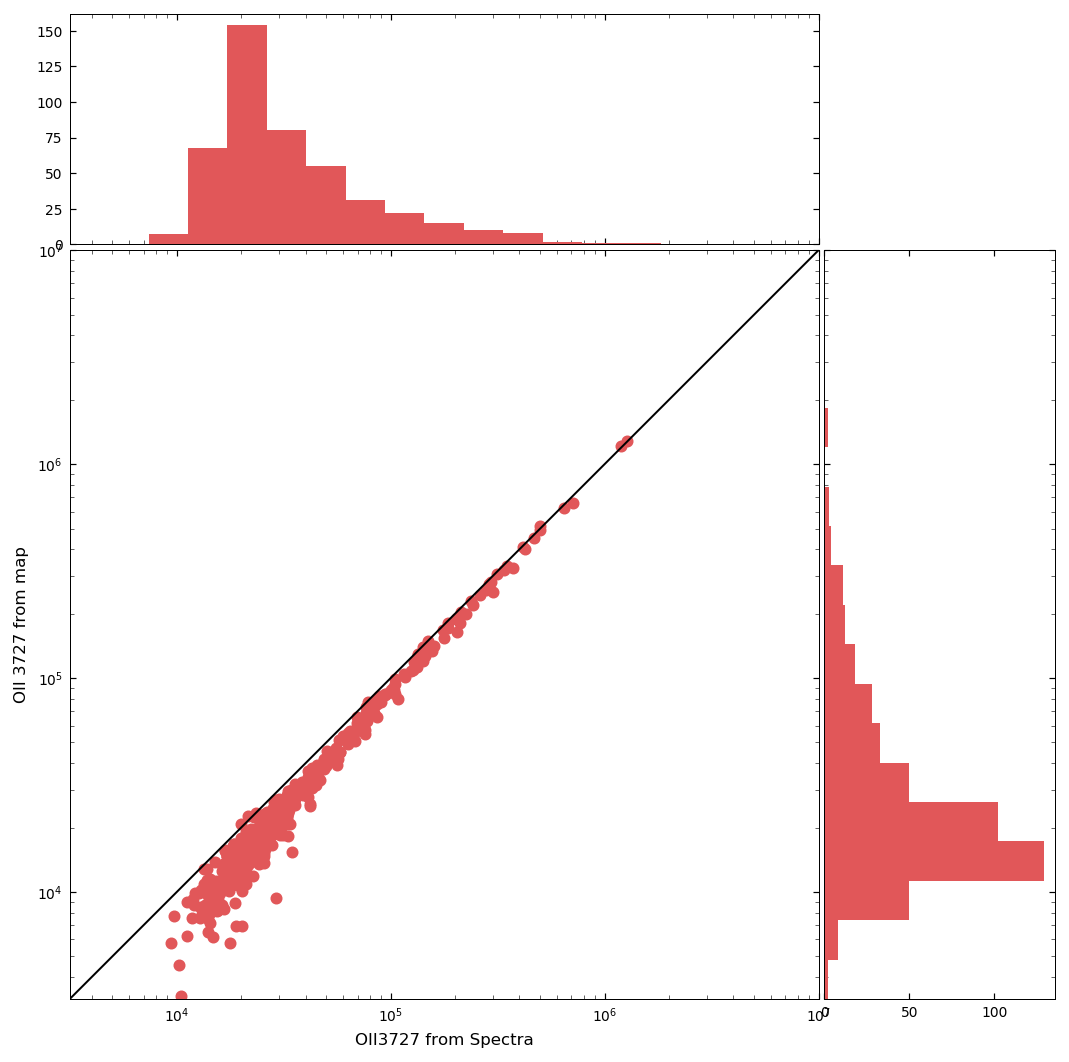

In [35]:
criteria = nebulae_with_OII['OII3726_FLUX_CORR']>3*nebulae_with_OII['OII3726_FLUX_CORR_ERR']
x,y = nebulae_with_OII['OII3726_FLUX'][criteria],flux_from_map[criteria]
x,y = x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)]
y/=10.30570988180577

nbins = 20
lim   = np.array([3.5,7])


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]


fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# the scatter plot:
ax.scatter(x,y)
ax.plot(10**lim,10**lim,color='black')
ax_histx.hist(x, bins=np.logspace(*lim,nbins))
ax_histy.hist(y, bins=np.logspace(*lim,nbins), orientation='horizontal')

ax.set(xlim=10**lim,ylim=10**lim,xscale='log',yscale='log',
       xlabel='OII3727 from Spectra',ylabel='OII 3727 from map')
plt.show()

### reprojected vs native

In [23]:
name = 'NGC0628'

# read in the data
flux_file = basedir/'data'/'maps'/f'{name}_OII_map_reprojected.fits'
with fits.open(flux_file) as hdul:
    reprojected = NDData(data=hdul['OII3726_FLUX'].data,
                    meta=hdul['OII3726_FLUX'].header,
                    wcs=WCS(hdul['OII3726_FLUX'].header))
    
# read in the data
flux_file = basedir/'data'/'maps'/f'{name}_OII_map.fits'
with fits.open(flux_file) as hdul:
    native = NDData(data=hdul['OII3726_FLUX'].data,
                    meta=hdul['OII3726_FLUX'].header,
                    wcs=WCS(hdul['OII3726_FLUX'].header))
    
# we read in all necessary files to measure the flux from the region
with fits.open(basedir/'data'/'Nebulae_Catalogue_DR2_native_with_OII.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.degree,nebulae['cen_dec']*u.degree)
nebulae = nebulae[nebulae['gal_name']==name]
nebulae.add_index('region_ID')

In [26]:
from photutils import aperture_photometry, SkyCircularAperture

apertures = SkyCircularAperture(nebulae['SkyCoord'],2*u.arcsecond)

flux_native = aperture_photometry(native,apertures)['aperture_sum']
flux_reprojected = aperture_photometry(reprojected,apertures)['aperture_sum']

In [31]:
np.nanmean(flux_reprojected/flux_native)

10.30570988180577

### Plot regions over OII

In [ ]:
from region import Regions   
muse_regions = Regions(mask=nebulae_mask.data,projection=nebulae_mask.meta,bkg=-1)

muse_regions.plot(image=OII_reprojected,regions=False,
                     filename=basedir/'reports'/name/f'{name}_OII_regions.png',
                     xlabel='R.A.',ylabel='Dec.', 
                     percent=99.6)

### Compare with SIGNALS survey

#### Calculate the line ratios they use

In [8]:
from skimage.measure import find_contours
from regions import PixCoord, PolygonPixelRegion

def filter_table(table,**kwargs):
    '''filter a table with the given keyword arguments'''
    
    for k,v in kwargs.items():
        if k in table.colnames:
            table = table[np.isin(table[k],v)]
        else:
            raise ValueError(f'WARNING: invalid column name {k}')
    return table

def find_sky_region(mask,wcs):
    '''create a region object from a mask and wcs
    
    Returns:
    reg_pix : PixelRegion
    reg_sky : SkyRegion
    '''

    mask[:,[0,-1]]=1
    mask[[0,-1],:]=1

    # find the contours around the image to use as vertices for the PixelRegion
    contours = find_contours(mask,0.5,)
    # we use the region with the most vertices
    coords = max(contours,key=len)
    #coords = np.concatenate(contours)

    # the coordinates from find_counters are switched compared to astropy
    reg_pix  = PolygonPixelRegion(vertices = PixCoord(*coords.T[::-1])) 
    reg_sky  = reg_pix.to_sky(wcs)
    
    return reg_pix, reg_sky

reg_muse_pix, reg_muse_sky = find_sky_region(Halpha.mask.astype(int),wcs=Halpha.wcs)

In [18]:
if name!='NGC0628':
    raise ValueError(f'current Galaxy is {name} and not NGC0628')
with open(basedir/'SIGNALS'/'columns.txt') as f:
    txt = f.read()
names = txt.split('\n')
#with fits.open(basedir/'SIGNALS'/'NGC628_catalog.fits') as hdul:
#    signals = Table(hdul[0].data,names=names)
with fits.open(basedir/'SIGNALS'/'NGC628_catalog_WCS_corr.fits') as hdul:
    signals = Table(hdul[0].data,names=names)
    
with fits.open(basedir/'data_v2p1'/'Nebulae_catalogue_v2.fits' ) as hdul:
    nebulae_catalogue = Table(hdul[1].data)
nebulae_catalogue = nebulae_catalogue[nebulae_catalogue['gal_name']==name]
nebulae_catalogue['SkyCoord'] = SkyCoord(nebulae_catalogue['cen_ra']*u.degree,nebulae_catalogue['cen_dec']*u.degree)
with fits.open(basedir/'data_v2p1'/'fluxes'/'NGC0628_OII_fluxes.fits') as hdul:
    OII_fluxes = Table(hdul[1].data)
nebulae_catalogue = join(nebulae_catalogue,OII_fluxes,keys=['gal_name','region_ID'])
    
signals['SkyCoord'] = SkyCoord(signals['RA']*u.degree,signals['DEC']*u.degree)
signals['HA_FLUX']  = signals['HA_FLUX_CORR'] / (4*np.pi*(9.552*u.Mpc).to(u.cm)**2)
signals['NII6583_FLUX'] = signals['HA_FLUX']* np.exp(signals['log(NII6583/HA)'])
signals['OII3727_FLUX'] = signals['NII6583_FLUX']* np.exp(signals['log(OII3727/NII6583)'])
signals['OIII5007_FLUX'] = signals['NII6583_FLUX']* np.exp(signals['log(OIII5007/NII6583)'])
signals['in_frame'] = reg_muse_sky.contains(signals['SkyCoord'],Halpha.wcs)

def calculate_ratios(tbl):
    '''
    caculate the signals line ratios for the MUSE nebulae catalogue
    
    'log(NII6583/HA)',
    'log(SII6716+6731/HA)',
    'log(SII6716+6731/NII6583)',
    'log(OIII5007/HB)',
    'log(OII3727/HB)',
    'log(OII3727+OII5007/HB)',
    'log(OIII5007/OII3727 )',
    'log(OIII5007/NII6583 )',
    'log(OII3727/NII6583)',
    'log(SII6717/SII6731)'
    ''' 
    
    with np.errstate(divide='ignore'):
        tbl['NII6583/HA'] = np.log10(tbl['NII6583_FLUX_CORR']/tbl['HA6562_FLUX_CORR'])
        tbl['SII6716+6731/HA'] = np.log10((tbl['SII6716_FLUX_CORR']+tbl['SII6730_FLUX_CORR'])/tbl['HA6562_FLUX_CORR'])
        tbl['SII6716+6731/NII6583'] = np.log10((tbl['SII6716_FLUX_CORR']+tbl['SII6730_FLUX_CORR'])/tbl['NII6583_FLUX_CORR'])
        tbl['OIII5007/HB'] = np.log10(tbl['OIII5006_FLUX_CORR']/tbl['HB4861_FLUX_CORR'])
        tbl['OIII5007/NII6583'] = np.log10(tbl['OIII5006_FLUX_CORR']/tbl['NII6583_FLUX_CORR'])
        tbl['SII6717/SII6731'] = np.log10(tbl['SII6716_FLUX_CORR']/tbl['SII6730_FLUX_CORR'])    
        tbl['SII6717/SII6731'] = np.log10(tbl['SII6716_FLUX_CORR']/tbl['SII6730_FLUX_CORR'])    
        tbl['OII3727/HB'] = np.log10(tbl['OII3726_FLUX_CORR']/tbl['HB4861_FLUX_CORR'])    
    return tbl

HII_regions = calculate_ratios(nebulae_catalogue)

/home/fabian/miniconda3/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in log10


In [25]:
from astropy.coordinates import match_coordinates_sky, Angle

matchcoord   = HII_regions[HII_regions['region_area']<100]
catalogcoord = signals[signals['in_frame']]

idx,sep,_=match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])
crit = sep.__lt__(Angle('.5"'))

lines = ['log(NII6583/HA)','log(SII6716+6731/HA)',
         'log(OIII5007/HB)','log(OIII5007/NII6583)','log(SII6717/SII6731)',
         'log(OII3727/HB)']

for line in lines:
    matchcoord[line] = catalogcoord[idx][line]
matchcoord['HA_signals'] = 1e20*(catalogcoord[idx]['HA_FLUX']*u.cm**2).value
matchcoord = matchcoord[crit]

#print(f'SIGNALS in MUSE frame: {np.sum(catalogcoord["in_frame"])}')
print(f'{np.sum(crit)} matches')

682 matches


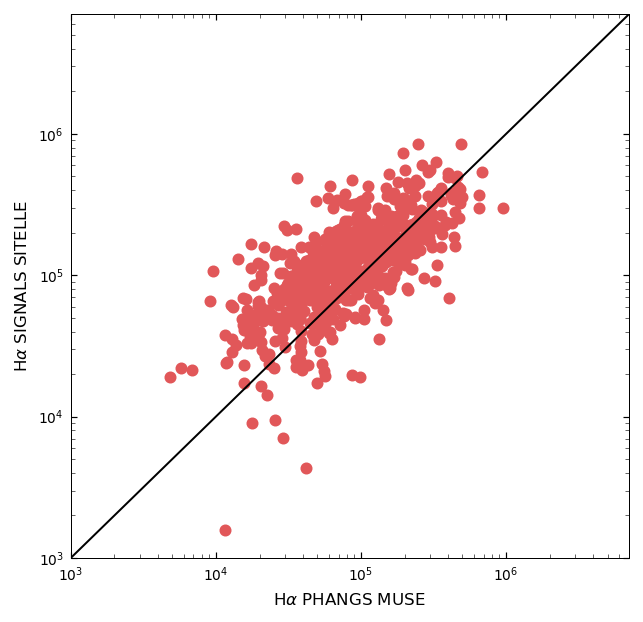

In [26]:
lim = 1e3,7e6
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(matchcoord['HA6562_FLUX_CORR'],matchcoord['HA_signals'])
ax.plot(lim,lim,color='black')
ax.set(xlim=lim,ylim=lim,xlabel=r'H$\alpha$ PHANGS MUSE',ylabel=r'H$\alpha$ SIGNALS SITELLE',xscale='log',yscale='log')
plt.show()

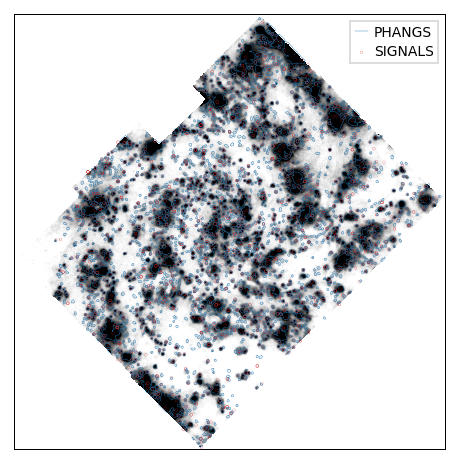

In [13]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(projection=Halpha.wcs)

norm = simple_norm(Halpha.data,clip=False,stretch='asinh',percent=80)
ax.imshow(Halpha.data,norm=norm,cmap=plt.cm.Greys)

x,y = catalogcoord[idx]['SkyCoord'].to_pixel(Halpha.wcs)
plt.scatter(x,y,marker='o',fc='none',ec='tab:red',s=2,lw=0.1,label='SIGNALS')

for coords in muse_regions.contours[:-1]: 
    ax.plot(coords[:,1],coords[:,0],color='tab:blue',lw=0.2)

ax.plot(muse_regions.contours[-1][:,1],muse_regions.contours[-1][:,0],color='tab:blue',lw=0.2,label='PHANGS')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_ticks_visible(False)
lon.set_ticklabel_visible(False)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lon.set_axislabel('')
lat.set_axislabel('')

plt.legend()
plt.savefig(basedir/'reports'/name/f'{name}_signals_regions.pdf',dpi=600)
plt.show()

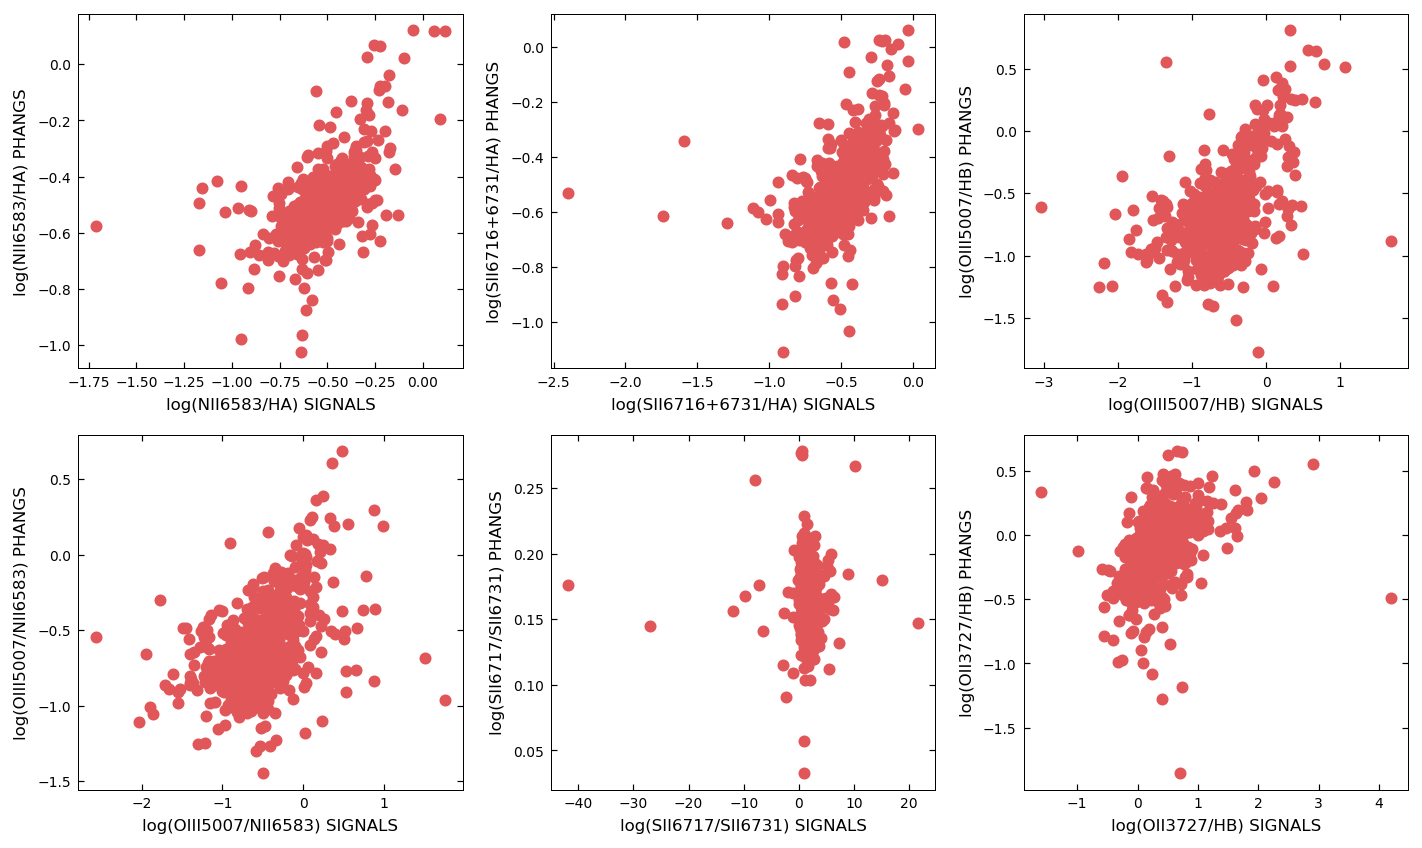

In [27]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(10,6))

axes_iter=iter(axes.flatten())

for line in lines:
    ax = next(axes_iter)
    
    ax.scatter(matchcoord[line],matchcoord[line[4:-1]])
    #ax.plot([-3,3],[-3,3])
    ax.set(xlabel=f'{line} SIGNALS',ylabel=f'{line} PHANGS')
plt.tight_layout()
#plt.savefig(basedir/'reports'/name/f'{name}_muse_regions_line_ratios_vs_signal.png')
plt.show()

#### Remeasure fluxes 

we use the positions from Rousseau-Nepton+2018 to measure the line fluxes in the MUSEDAP

In [28]:
columns = ['ID','SkyCoord','log(NII6583/HA)','log(SII6716+6731/HA)',
         'log(OIII5007/HB)','log(OIII5007/NII6583)','log(SII6717/SII6731)']

sample = signals[columns][signals['in_frame']].copy()

In [29]:
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

apertures = SkyCircularAperture(sample['SkyCoord'],1*u.arcsec)
annuli    = SkyCircularAnnulus(sample['SkyCoord'],3*u.arcsec,4*u.arcsec)

with fits.open(data_raw/'MUSE_DR2.1'/'MUSEDAP'/'NGC0628_MAPS.fits') as hdul:
    for line in ['HB4861','OIII5006','HA6562','NII6583','SII6716','SII6730']:
        data = hdul[f'{line}_FLUX'].data
        wcs  = WCS(hdul[f'{line}_FLUX'].header)
        sample[line] = aperture_photometry(data,apertures,wcs=wcs)['aperture_sum']
        sample[f'{line}_bkg'] = aperture_photometry(data,annuli,wcs=wcs)['aperture_sum'] / 4

sample['HB4861']   = sample['HB4861'] - sample['HB4861_bkg']
sample['OIII5006'] = sample['OIII5006'] - sample['OIII5006_bkg']
sample['HA6562']   = sample['HA6562'] - sample['HA6562_bkg']
sample['NII6583']  = sample['NII6583'] - sample['NII6583_bkg']
sample['SII6716']  = sample['SII6716'] - sample['SII6716_bkg']
sample['SII6730']  = sample['SII6730'] - sample['SII6730_bkg']

sample['NII6583/HA']       = sample['NII6583']/sample['HA6562']
sample['SII6716+6731/HA']  = (sample['SII6716']+sample['SII6730'])/sample['HA6562']
sample['OIII5007/HB']      = sample['OIII5006']/sample['HB4861']
sample['OIII5007/NII6583'] = sample['OIII5006']/sample['NII6583']
sample['SII6717/SII6731']  = sample['SII6716']/sample['SII6730']

OSError: [Errno 22] Invalid argument: '/mnt/g/MUSE_DR2.1/MUSEDAP/NGC0628_MAPS.fits'

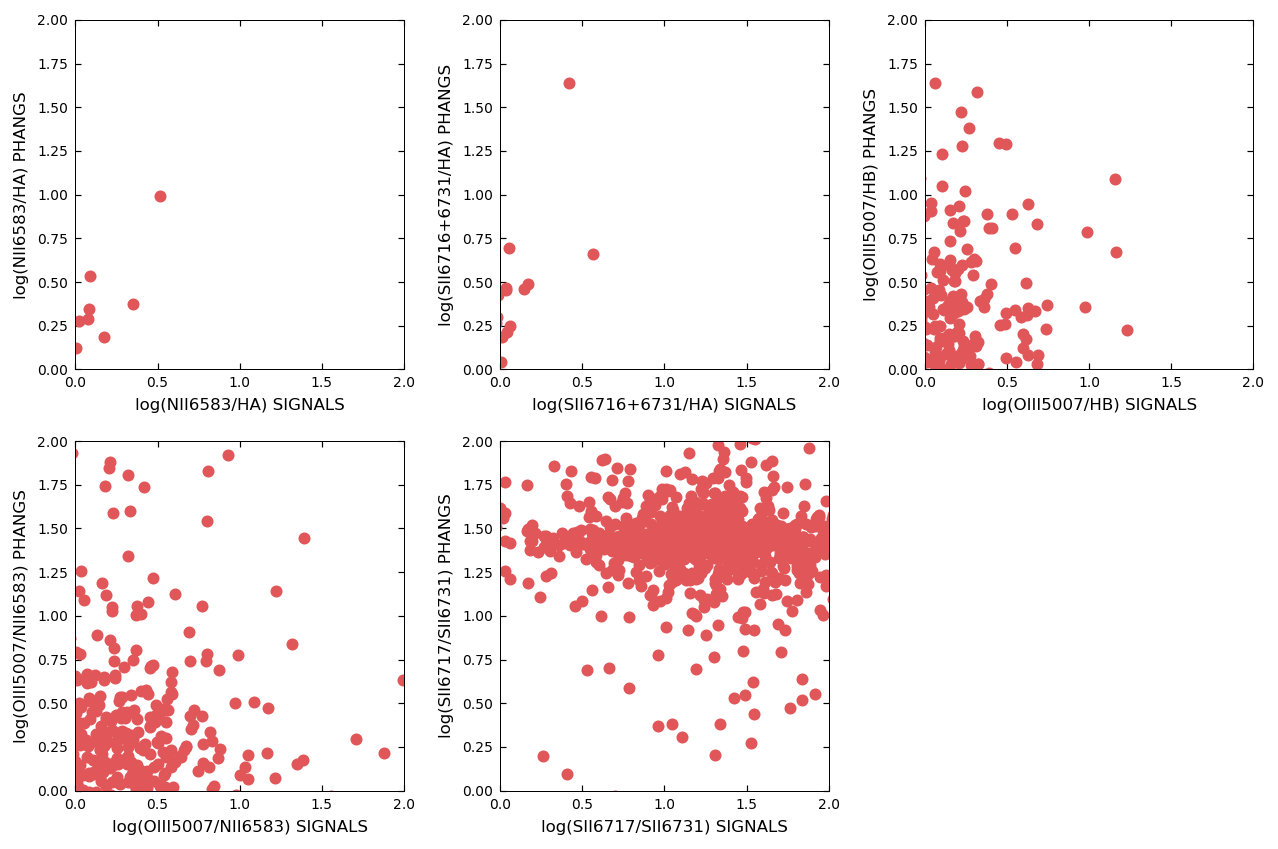

In [67]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(9,6))

axes_iter=iter(axes.flatten())

for line in columns[2:]:
    ax = next(axes_iter)
    
    ax.scatter(sample[line],sample[line[4:-1]])
    #ax.plot([-3,3],[-3,3])
    ax.set(xlabel=f'{line} SIGNALS',ylabel=f'{line} PHANGS')
    ax.set(xlim=[0,2],ylim=[0,2])
    
ax = next(axes_iter)
ax.remove()
plt.tight_layout()
plt.savefig(basedir/'reports'/name/f'{name}_signal_regions_line_ratios.png')
plt.show()

### Astrometry

In [ ]:
name = 'NGC0628'
data_ext = Path('a:')

with fits.open(data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits') as hdul:
    WFI = NDData(data=hdul[0].data,
                 meta=hdul[0].header,
                 wcs=WCS(hdul[0].header))
    
with fits.open(data_ext/'MUSE_DR2'/'MUSEDAP'/f'{name}_MAPS.fits') as hdul:    
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))    
    
with fits.open(data_ext/'SITELLE'/f'{name}_cube.fits') as hdul:
    wcs = WCS(hdul[0].header,naxis=2)

with fits.open(data_ext/'SITELLE'/f'{name}_deepframe.fits') as hdul:
    deepframe = NDData(data=hdul[0].data,
                    meta=hdul[0].header,
                    wcs=WCS(hdul[0].header))    
    

In [ ]:
from reproject import reproject_interp

deepframe_wfi = reproject_interp((deepframe.data,wcs),Halpha.meta,return_footprint=False)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection=Halpha.wcs)

norm = simple_norm(Halpha.data,clip=False,percent=99)
ax.imshow(Halpha.data,norm=norm,cmap=plt.cm.Greys)

#norm = simple_norm(deepframe_wfi,clip=False,percent=99)
#ax.imshow(deepframe_wfi,norm=norm,cmap=plt.cm.Greys)
plt.savefig('wfi.png',dpi=600)
plt.show()

## Playground